# 1. Data importation

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [ ]:
#set the path to where the data is saved
df = pd.read_csv('path to data')

# 2. Functions used

In [ ]:
def clean(data):
  clean = data.copy()
  target = data.columns[data.isna().any()].tolist()
  for t in target:
    index = clean[clean[t].isna()].index
    for idx in index:
      clean.loc[idx, t] = clean.loc[0:idx, t].mean()

  return clean

In [ ]:
def OLS_allvar(scaled_train, scaled_test, clean_df, w, a, split_time=split_time):
  X_train = np.zeros((scaled_train.shape[0]-w-(a-1), w+5)) #(Ntrain-w-(a-1) x w+1)
  X_test = np.zeros((scaled_test.shape[0]-w-(a-1), w+5)) #(Ntest-w-(a-1) x w+1)
  for wi in range(w):
    X_train[:,wi] = scaled_train[wi:-w-(a-1)+wi]
    X_test[:,wi] = scaled_test[wi:-w-(a-1)+wi]
  for ni,n in enumerate(['DOY.h', 'SSN', 'Kp', 'Dst', 'TEC']):
    n_train = np.array(clean_df.loc[:split_time, n])
    if ni==0: X_train[:,w+ni] = n_train[w+(a-1):]
    else: X_train[:,w+ni] = n_train[w+(a-1)-1:-1]
    n_test = np.array(clean_df.loc[split_time:, n])
    if ni==0: X_test[:,w+ni] = n_test[w+(a-1):]
    else: X_test[:,w+ni] = n_test[w+(a-1)-1:-1]

  Y_train = scaled_train[w+(a-1):] #(Ntrain-w-(a-1) x 1)
  Y_test = scaled_test[w+(a-1):] #(Ntest-w-(a-1) x 1)

  Sx = 1/(scaled_train.shape[0]-w-(a-1)) * np.matmul(X_train.T, X_train) #(w+1 x w+1)
  Sxy = 1/(scaled_train.shape[0]-w-(a-1)) * np.matmul(X_train.T, Y_train) #(w+1 x 1)
  wOLS = np.matmul(np.linalg.inv(Sx), Sxy) #(w+1 x 1)
  bOLS = np.mean(Y_train) - np.matmul(np.mean(X_train, axis=0), wOLS) #(1 x 1)

  Y_pred = np.matmul(X_test, wOLS) + bOLS

  return Y_test, Y_pred

# 3. Data preprocessing

In [ ]:
split_time = int(0.8*len(df))

In [ ]:
clean_df = clean(df)

train_m = np.array(clean_df.loc[:split_time, 'foF2m'])
test_m = np.array(clean_df.loc[split_time:, 'foF2m'])
train_o = np.array(clean_df.loc[:split_time, 'foF2o'])
test_o = np.array(clean_df.loc[split_time:, 'foF2o'])

# 4. Overview of the datasets

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax.plot(np.arange(test_m.shape[0]), test_m, 'k.-')
ax2.plot(np.arange(test_o.shape[0]), test_o, 'k.-')
ax.set_xlim(0,24*3)
ax.grid()
ax2.grid()
ax.set_ylim(3,13)
ax.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax2.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax.set_ylabel('foF2 (MHz)')
ax.set_title('Modeled foF2')
ax2.set_title('Observed foF2')

plt.tight_layout()

# 5. Overview of forecasts (a={1,8}, w={2,8,24})

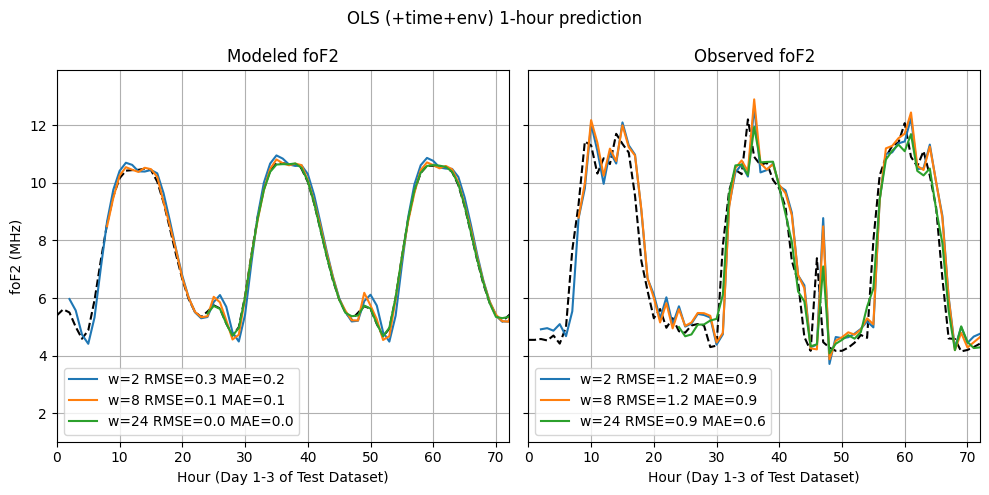

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax.plot(np.arange(test_m.shape[0]), test_m, 'k--')
ax2.plot(np.arange(test_o.shape[0]), test_o, 'k--')
for w in [2,8,24]:
  Y_test, Y_pred = OLS_allvar(train_m, test_m, clean_df, w, 1)
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  MAE = np.mean(np.abs(Y_pred - Y_test))
  ax.plot(np.arange(w, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.1f} MAE={MAE:.1f}')
  Y_test, Y_pred = OLS_allvar(train_o, test_o, clean_df, w, 1)
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  MAE = np.mean(np.abs(Y_pred - Y_test))
  ax2.plot(np.arange(w, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.1f} MAE={MAE:.1f}')
ax.set_xlim(0,24*3)
ax.legend(loc='lower left')
ax.grid()
ax2.legend()
ax2.grid()
ax.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax2.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax.set_ylabel('foF2 (MHz)')
ax.set_title('Modeled foF2')
ax2.set_title('Observed foF2')
fig.suptitle('OLS (+time+env) 1-hour prediction')

plt.tight_layout()

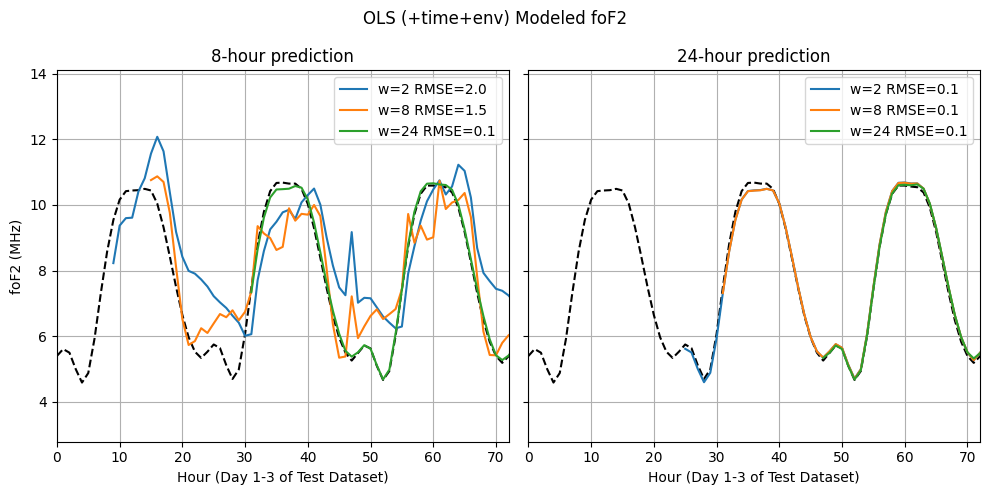

In [ ]:
fig, (ax,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
ax.plot(np.arange(test_m.shape[0]), test_m, 'k--')
ax2.plot(np.arange(test_m.shape[0]), test_m, 'k--')
for w in [2,8,24]:
  a = 8
  Y_test, Y_pred = OLS_allvar(train_m, test_m, clean_df, w, a)
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  ax.plot(np.arange(w+a-1, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.1f}')
  a = 24
  Y_test, Y_pred = OLS_allvar(train_m, test_m, clean_df, w, a)
  RMSE = np.sqrt(np.mean((Y_pred - Y_test)**2))
  ax2.plot(np.arange(w+a-1, test_m.shape[0]), Y_pred, label=f'w={w} RMSE={RMSE:.1f}')
ax.set_xlim(0,24*3)
ax.legend(loc='upper right')
ax.grid()
ax2.legend()
ax2.grid()
ax.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax2.set_xlabel('Hour (Day 1-3 of Test Dataset)')
ax.set_ylabel('foF2 (MHz)')
ax.set_title('8-hour prediction')
ax2.set_title('24-hour prediction')
fig.suptitle('OLS (+time+env) Modeled foF2')

plt.tight_layout()

## 6. Window size VS forecasting # hours ahead

In [ ]:
RMSE_m = np.zeros((48,47)) * np.nan
RMSE_o = np.zeros((48,47)) * np.nan
for ai,a in enumerate(range(1,49)):
  for wi,w in enumerate(range(2,49)):
    Y_test, Y_pred = OLS_allvar(train_m, test_m, clean_df, w, a)
    RMSE_m[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))
    Y_test, Y_pred = OLS_allvar(train_o, test_o, clean_df, w, a)
    RMSE_o[ai,wi] = np.sqrt(np.mean((Y_pred - Y_test)**2))

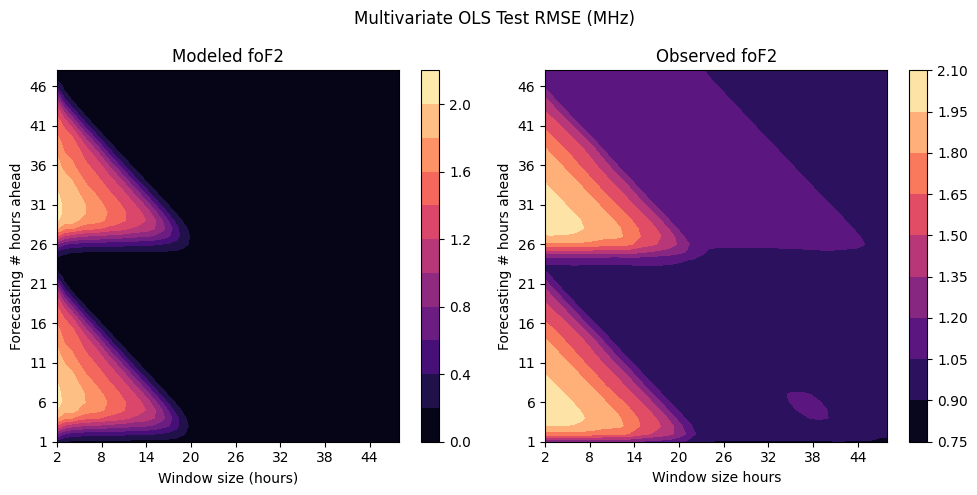

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma', levels=10)
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Forecasting # hours ahead')
ax.set_xticks(np.arange(0,47,6))
ax.set_xticklabels(np.arange(2,49,6))
ax.set_yticks(np.arange(0,48,5))
ax.set_yticklabels(np.arange(1,49,5))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma', levels=10)
ax2.set_xlabel('Window size hours')
ax2.set_ylabel('Forecasting # hours ahead')
ax2.set_xticks(np.arange(0,47,6))
ax2.set_xticklabels(np.arange(2,49,6))
ax2.set_yticks(np.arange(0,48,5))
ax2.set_yticklabels(np.arange(1,49,5))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate OLS Test RMSE (MHz)')
plt.tight_layout()

## 7. Window size VS hour of forecast

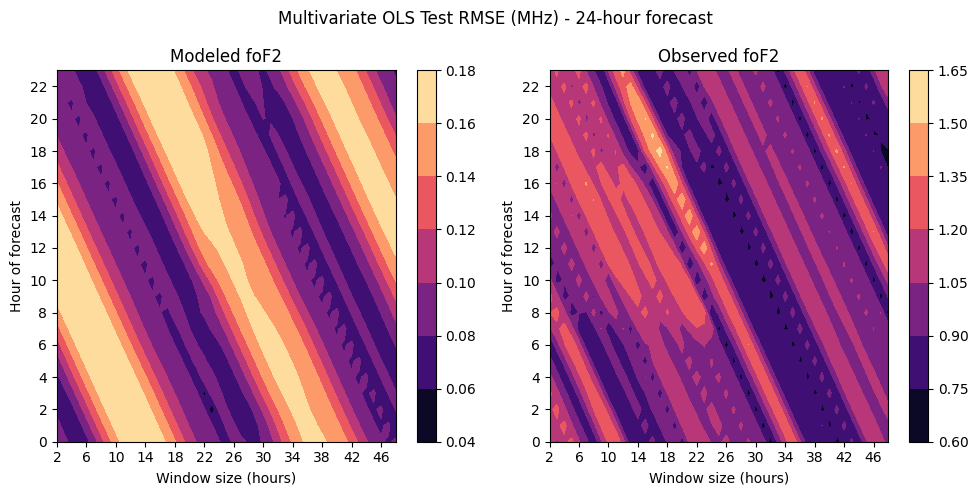

In [ ]:
RMSE_m = np.zeros((24,47)) * np.nan
RMSE_o = np.zeros((24,47)) * np.nan
for wi,w in enumerate(range(2,49)):
  Y_test, Y_pred = OLS_allvar(train_m, test_m, clean_df, w, 24)
  RMSE_m[:,wi] = [np.sqrt(np.mean((Y_pred[h::24] - Y_test[h::24])**2)) for h in range(24)]
  Y_test, Y_pred = OLS_allvar(train_o, test_o, clean_df, w, 24)
  RMSE_o[:,wi] = [np.sqrt(np.mean((Y_pred[h::24] - Y_test[h::24])**2)) for h in range(24)]

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Hour of forecast')
ax.set_xticks(np.arange(0,47,4))
ax.set_xticklabels(np.arange(2,49,4))
ax.set_yticks(np.arange(0,24,2))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Hour of forecast')
ax2.set_xticks(np.arange(0,47,4))
ax2.set_xticklabels(np.arange(2,49,4))
ax2.set_yticks(np.arange(0,24,2))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate OLS Test RMSE (MHz) - 24-hour forecast')
plt.tight_layout()

# 8. Window size VS hour of forecast (daily windowing)

In [ ]:
RMSE_m = np.zeros((24,21)) * np.nan
RMSE_o = np.zeros((24,21)) * np.nan
for h in range(24):
  for wi,w in enumerate(range(2,43,2)):
    Y_test, Y_pred = OLS_allvar(train_m[h::24], test_m[h::24], clean_df.loc[h::24], w, 1)
    RMSE_m[h,wi] = np.sqrt(np.mean((Y_pred-Y_test)**2))
    Y_test, Y_pred = OLS_allvar(train_o[h::24], test_o[h::24], clean_df.loc[h::24], w, 1)
    RMSE_o[h,wi] = np.sqrt(np.mean((Y_pred-Y_test)**2))

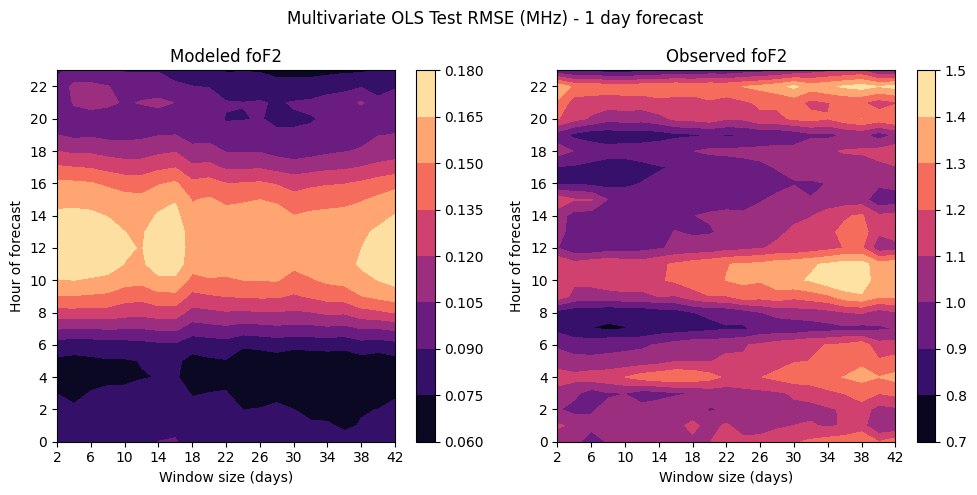

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma')
ax.set_xlabel('Window size (days)')
ax.set_ylabel('Hour of forecast')
ax.set_xticks(np.arange(0,21,2))
ax.set_xticklabels(np.arange(2,43,4))
ax.set_yticks(np.arange(0,24,2))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma')
ax2.set_xlabel('Window size (days)')
ax2.set_ylabel('Hour of forecast')
ax2.set_xticks(np.arange(0,21,2))
ax2.set_xticklabels(np.arange(2,43,4))
ax2.set_yticks(np.arange(0,24,2))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate OLS Test RMSE (MHz) - 1 day forecast')
plt.tight_layout()

# 9. Recursive Least Squares (BONUS)

In [ ]:
def RLS_allvar(clean_df, w, a, allvar=1, data='foF2m', fh=0):

  if allvar: dim = w+5
  else: dim = w
  X_train_ext = np.hstack((np.zeros(w), clean_df[data]))
  theta = np.zeros(dim)
  P = np.identity(dim)
  lam = 0.98
  SE = np.zeros((24,int((clean_df[data].size-a-w)/24))) * np.nan
  for t in range(int((clean_df[data].size-a-w)/24)*24): # t from 0 to len(x)-a (if extend X[-w:0] = 0) else t from w to len(x)-a

      time = np.array(clean_df['DOY.h'])[t+w-1]
      SSN = np.array(clean_df['SSN'])[t+w-1]
      Dst = np.array(clean_df['Dst'])[t+w-1]
      TEC = np.array(clean_df['TEC'])[t+w-1]
      Kp = np.array(clean_df['Kp'])[t+w-1]
      x_t = X_train_ext[t:t+w][::-1] # X[t:t-w-1::-1] for [x(t), ..., x(t-w)]
      if allvar: x_t = np.hstack((x_t, [time, SSN, Kp, Dst, TEC]))
      y_t = X_train_ext[t+w+(a-1)] # X[t+h] for d(t)=x(t+h) (predicting a hours ahead)

      alpha = y_t - np.dot(x_t, theta)
      g = np.matmul(P, x_t) / (lam + np.matmul(np.matmul(x_t.T, P), x_t))
      P = 1/lam * (P - np.matmul(np.outer(g, x_t), P))
      theta = theta + alpha * g

      y_hat_t = np.dot(theta, x_t)

      hour = int(np.round((time - np.floor(time))*24))

      SE[hour,int(t/24)] = (y_t - y_hat_t)**2

  RMSE_h = np.sqrt(np.sum(SE, axis=1)/(t+1)*24)
  RMSE_all = np.sqrt(np.mean(SE))

  if fh: #forecast hour
    return RMSE_h
  else:
    return RMSE_all


In [ ]:
RMSE_m = np.zeros((24,47)) * np.nan
RMSE_o = np.zeros((24,47)) * np.nan
for wi,w in enumerate(range(2,49)):
  print(w)
  RMSE_m[:,wi] = RLS_allvar(clean_df, w, 24, fh=1)
  RMSE_o[:,wi] = RLS_allvar(clean_df, w, 24, data='foF2o', fh=1)

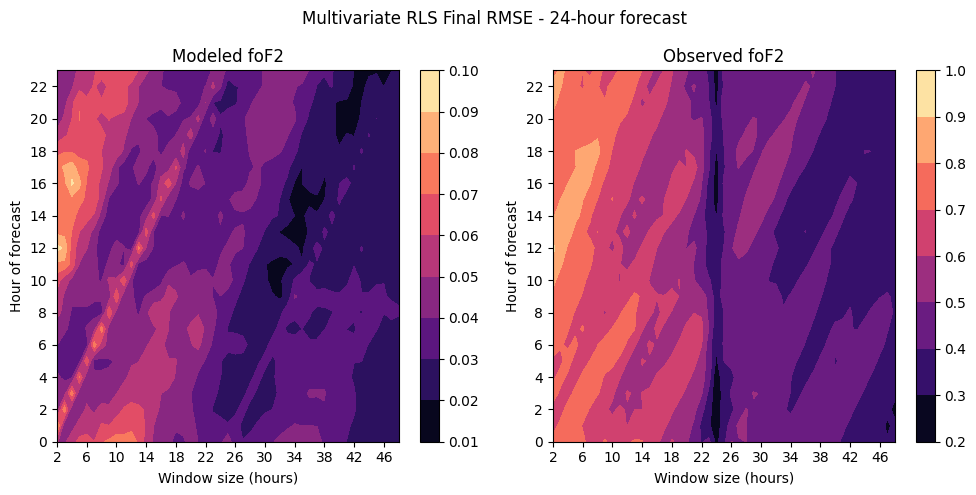

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Hour of forecast')
ax.set_xticks(np.arange(0,47,4))
ax.set_xticklabels(np.arange(2,49,4))
ax.set_yticks(np.arange(0,24,2))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Hour of forecast')
ax2.set_xticks(np.arange(0,47,4))
ax2.set_xticklabels(np.arange(2,49,4))
ax2.set_yticks(np.arange(0,24,2))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate RLS Final RMSE (MHz) - 24-hour forecast')

plt.tight_layout()

In [ ]:
RMSE_m = np.zeros((24,21)) * np.nan
RMSE_o = np.zeros((24,21)) * np.nan
for h in range(24):
  print(h)
  for wi,w in enumerate(range(2,43,2)):
    RMSE_m[h,wi] = RLS_allvar(clean_df.loc[h::24], w, 1, data='foF2m', fh=1)[h]
    RMSE_o[h,wi] = RLS_allvar(clean_df.loc[h::24], w, 1, data='foF2o', fh=1)[h]

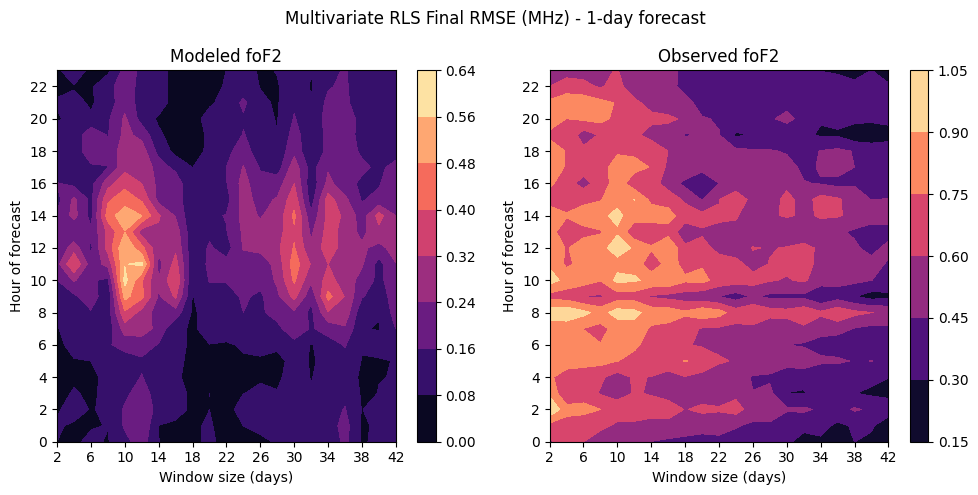

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma')
ax.set_xlabel('Window size (days)')
ax.set_ylabel('Hour of forecast')
ax.set_xticks(np.arange(0,21,2))
ax.set_xticklabels(np.arange(2,43,4))
ax.set_yticks(np.arange(0,24,2))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma')
ax2.set_xlabel('Window size (days)')
ax2.set_ylabel('Hour of forecast')
ax2.set_xticks(np.arange(0,21,2))
ax2.set_xticklabels(np.arange(2,43,4))
ax2.set_yticks(np.arange(0,24,2))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate RLS Final RMSE (MHz) - 1-day forecast')

fig.tight_layout()

In [ ]:
RMSE_m = np.zeros((np.arange(1,49,4).size, np.arange(2,49,4).size)) * np.nan
RMSE_o = np.zeros((np.arange(1,49,4).size, np.arange(2,49,4).size)) * np.nan
for ai,a in enumerate(np.arange(1,49,4)):
  for wi,w in enumerate(np.arange(2,49,4)):
    RMSE_m[ai,wi] = RLS_allvar(clean_df, w, a, data='foF2m')
    RMSE_o[ai,wi] = RLS_allvar(clean_df, w, a, data='foF2o')

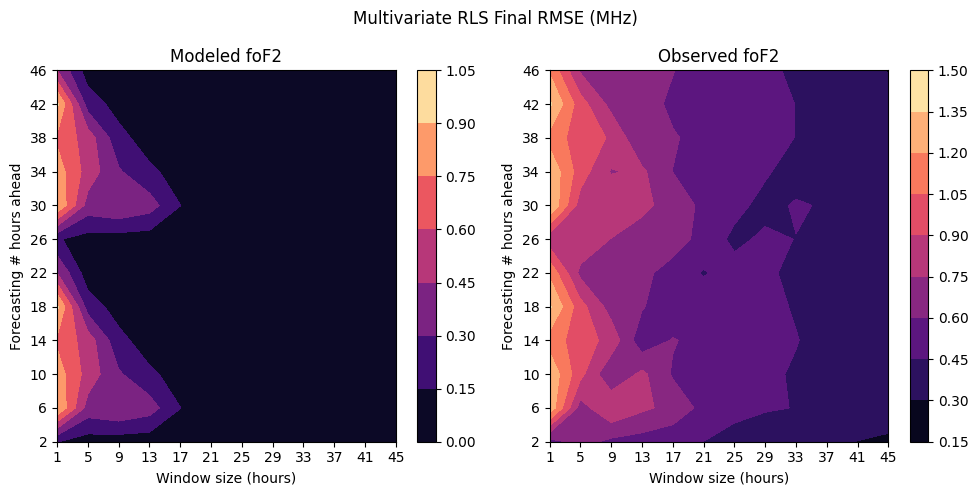

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,5))

cax = ax.contourf(RMSE_m, cmap='magma')
ax.set_xlabel('Window size (hours)')
ax.set_ylabel('Forecasting # hours ahead')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(np.arange(1,49,4))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(np.arange(2,49,4))
ax.set_title('Modeled foF2')
fig.colorbar(cax)

cax2 = ax2.contourf(RMSE_o, cmap='magma')
ax2.set_xlabel('Window size (hours)')
ax2.set_ylabel('Forecasting # hours ahead')
ax2.set_xticks(np.arange(12))
ax2.set_xticklabels(np.arange(1,49,4))
ax2.set_yticks(np.arange(12))
ax2.set_yticklabels(np.arange(2,49,4))
ax2.set_title('Observed foF2')
fig.colorbar(cax2)

fig.suptitle('Multivariate RLS Final RMSE (MHz)')

plt.tight_layout()